In [16]:
#Importing relevant modules etc.

import operator
import numpy as np
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from scipy.special import comb


#TF2 Approach

#Group 1: D4

#Model subclassing - model that takes x1 and x2, constructs X and multiplies by Beta to give estimated y1 and y2

class HilbertBasis(layers.Layer):
    """Constructs Hilbert basis for given group."""

    def __init__(
        self, 
        group, 
        output_dim,
        input_dim,
        name="hilbertbasis",
        **kwargs
    ):
        super(HilbertBasis, self).__init__(name=name, **kwargs)
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.group = group
        
    def call(self, inputs):
        #inputs = [x_1,...,x_(input_dim)] for each example
        x = inputs
        print('input of HilbertBasis',inputs)
        if self.group==1:
            basis_elem_2 = tf.math.square(tf.math.square(x[:,0]))-6*tf.math.square(x[:,0])*tf.math.square(x[:,1])+tf.math.square(x[:,1])
            basis_elem_1 = tf.math.add(tf.math.square(x[:,0]),tf.math.square(x[:,1]))
            hilbert_basis = tf.stack([basis_elem_1,basis_elem_2],axis=1)
        #hilbert_basis = [pi_1,pi_2,...,pi_r] for each example
        print('output of HilbertBasis',hilbert_basis)
        return hilbert_basis
    
    
class FundEquivariants(layers.Layer):
    
    """Constructs fundamental equivariants for given group."""
    def __init__(
        self, 
        group, 
        output_dim,
        input_dim,
        name="fundamentalequivariants",
        **kwargs
    ):
        super(FundEquivariants, self).__init__(name=name, **kwargs)
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.group = group

    def call(self, inputs):
        x = inputs
        print('input of FundEquiv',inputs)
        if self.group==1:
            equiv_elem_1 = x
            equiv_elem_2 = tf.stack([tf.math.pow(x[:,0],3)-3*tf.math.multiply(x[:,0],tf.math.pow(x[:,1],2)),
                                    -tf.math.pow(x[:,1],3)-3*tf.math.multiply(x[:,1],tf.math.pow(x[:,0],2))],
                                    axis=1)
            fund_equivariants = tf.stack([equiv_elem_1,equiv_elem_2],axis=1)
        print('output of FundEquiv',fund_equivariants)
        return fund_equivariants
                                  
        

class iDegreePolynomialAlt(layers.Layer):
    """Constructs r^i (fund_equivariants_dim^i) matrix M containing all factors of degree i=poly_degree in
    the polynomial."""

    def __init__(
        self, 
        group, 
        output_dim,
        input_dim,
        hilbert_basis_dim,
        maxdegree,
        name="idegreepolynomialalt",
        **kwargs
    ):
        super(iDegreePolynomialAlt, self).__init__(name=name, **kwargs)
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.group = group
        self.hilbert_basis_dim = hilbert_basis_dim
        self.max_degree = maxdegree
        
    def build(self, input_shape):
        
        self.beta = tf.concat([tf.Variable(
                initial_value = tf.keras.initializers.RandomNormal(mean=0., stddev=1)
            (shape=(int(comb(self.input_dim+d-1,self.input_dim-1)),)),
                dtype=tf.dtypes.float32,
                trainable=True)  for d in range(self.max_degree+1)],axis=0,name='beta')
        
        #Mean and variance of uniform distribution of x
        a,b = 0,1    
            
        #In-built scaling
        for d in range(self.max_degree+1):
            #Calculate expectation of x^d and expectation of x^(2d)
            a_k = [a^i for i in range(d)]
            b_ik = [b^(d-i) for i in range(d)]
            exp_d = tf.math.multiply(tf.math.pow(i+d,-1),tf.math.reduce_sum(tf.math.multiply(a_k,b_ik)))
            a_2k = [a^i for i in range(2*d)]
            b_2ik = [b^(2*d-i) for i in range(2*d)]            
            exp_2d = tf.math.multiply(tf.math.pow(2*d+1,-1),tf.math.reduce_sum(tf.math.multiply(a_2k,b_2ik)))
            #Calculate variance of X
            variance = exp_2d - tf.math.pow(exp_d,2)
            #Calculate variance of beta
            nu = tf.math.pow(tf.math.multiply(d+1,variance),-1)
        #Initialise beta_alt with variance of 1
        beta_alt = tf.concat([tf.Variable(
                initial_value = tf.keras.initializers.RandomNormal(mean=0., stddev=1)
            (shape=(int(comb(self.input_dim+d-1,self.input_dim-1)),)),
                dtype=tf.dtypes.float32,
                trainable=True)  for d in range(self.max_degree+1)],axis=0,name='beta')  
        #Replace with new beta by multiplying with scaling
        self.beta = tf.math.multiply(tf.math.pow(nu,-0.5),beta_alt)
            
    def call(self, inputs, mask=None):
        #inputs = [[pi_1,...,pi_r],[F_(poly_degree)]]
        #**INPUTS ALL FUNDAMENTAL INVARIANTS BUT ONLY j=poly_degree FUNDAMENTAL EQUIVARIANTS**
        
        print('input of iDegreePolyAlt',inputs)

        #Obtain polynomial terms up to and including degree d
        poly = PolynomialFeatures(self.max_degree)
        P = poly.fit_transform(inputs[:,0,:self.hilbert_basis_dim])
        print('polynomial terms P',P
        
        #Multiply by beta and sum up for each example
        print('beta',self.beta)
        P = tf.math.multiply(P,self.beta)
        print('P after multiplying by beta',P)
        P = tf.math.reduce_sum(P,axis=-1)
        print('P after summing',P)
        
        #Multiply the fundamental equivariants by polynomial P
        P = tf.math.multiply(inputs[:,1],tf.expand_dims(P,1))
        print('output of iDegreePolyAlt',P)
        return P


    
    
class GroupEquivariantPolynomialApproximationAlt(tf.keras.Model):
    """Applies the polynomial transformation and approximates Y forming an end-to-end model for training."""

    def __init__(
        self, 
        group, 
        output_dim,
        input_dim,
        hilbert_basis_dim,
        fund_equivariants_dim,
        batch_size,
        max_degree,
        no_of_polynomials,
        name="gepaalt",
        **kwargs
    ):
        super(GroupEquivariantPolynomialApproximationAlt, self).__init__(name=name, **kwargs)
        self.group = group
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.hilbert_basis_dim = hilbert_basis_dim
        self.fund_equivariants_dim = fund_equivariants_dim
        self.batch_size = batch_size
        self.max_degree = max_degree
        self.no_of_polynomials = no_of_polynomials
        self.hilbertbasis = HilbertBasis(group=group, output_dim=output_dim, input_dim=input_dim)
        self.fundequivariants = FundEquivariants(group=group, output_dim=output_dim, input_dim=input_dim)
        self.i_degree_polys = [iDegreePolynomialAlt(maxdegree=self.max_degree ,group=self.group, output_dim=self.output_dim,
                                              input_dim=self.input_dim,
                                             hilbert_basis_dim=self.hilbert_basis_dim, name='{}'.format(i)) for i in range(self.no_of_polynomials)]

            
    def call(self, inputs):
        #inputs = [x_1,...,x_n] for each example
        x = inputs
        
        #Obtain Hilbert basis
        hilbert_basis = self.hilbertbasis(x)
        print('hilbert_basis',hilbert_basis)
        
        #Obtain fundamental equivariants
        fund_equivariants = self.fundequivariants(x)
        print('fund_equivariants',fund_equivariants)
        
        #Obtain polynomial approximation for all polynomials
        y_pred = tf.zeros([self.fund_equivariants_dim])
        for j in range(self.no_of_polynomials):
            inputs_j = tf.stack([hilbert_basis,fund_equivariants[:,j,:]],axis=1)
            print('input of iDegreePolyAlt in Model',inputs_j)
            layer = self.i_degree_polys[j]
            polynomial_j = layer(inputs_j)
            print('output of iDegreePolyAlt in Model',polynomial_j)
            y_pred = tf.math.add(y_pred,polynomial_j)
            print('output of Model',y_pred)
            
        
        return y_pred
    

    
    
#Instantiate model and training loop paramaters
n = 64
input_dim = 2
output_dim = 2
d_max = 3
batch_size = 32

model_alt = GroupEquivariantPolynomialApproximationAlt(group = 1, output_dim = output_dim,
                                                input_dim = input_dim, 
                                                hilbert_basis_dim = 2,
                                                fund_equivariants_dim = 2,
                                                batch_size = batch_size,
                                                max_degree = d_max,
                                                no_of_polynomials = 2)

#Define loss object
loss_object = tf.keras.losses.MeanAbsoluteError()

#Degine loss function
def loss_fn(y_true, y_pred):
    if y_true.shape!=y_pred.shape:
        print('ERROR')
    return loss_object(y_true=y_true, y_pred=y_pred)

#Prepare the metrics.
train_acc_metric = tf.keras.metrics.MeanAbsoluteError()
val_acc_metric = tf.keras.metrics.MeanAbsoluteError()

#Prepare training dataset
x_train = np.random.uniform(low=-6,high=6,size=(n,2))
g = x_train[:,0]**2+x_train[:,1]**2
#x_train = np.array([[i,i]for i in range(n)])
#g = x_train[:,0]**2+x_train[:,1]**2
#y_train = np.multiply(np.stack((g,g),axis=-1),x_train)
y_train = x_train

#Reserve samples for validation
n_2 = int(-n/2)
x_val = x_train[:,n_2:]
y_val = y_train[:,n_2:]
x_train = x_train[:,:-n_2]
y_train = y_train[:,:-n_2]

#Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
train_dataset = train_dataset.shuffle(n, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

#Prepare the validation datasest
val_dataset = tf.data.Dataset.from_tensor_slices((x_val.astype(np.float32), y_val.astype(np.float32)))
val_dataset = val_dataset.batch(batch_size)

#Printing output of model
# for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
#     logits = model_alt(x_batch_train, training=False)
# print(logits)

import time

def training_loop_on(optimizer):
    
    #Tensors for testing optimizers
    losses = []
    grads_list = []
    
    epochs = 50
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

            # Open a GradientTape to record the operations run
            # during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:

                # Run the forward pass of the layer.
                # The operations that the layer applies
                # to its inputs are going to be recorded
                # on the GradientTape.
                #logits = model(x_batch_train, training=True)  # Logits for this minibatch
                logits = model_alt(x_batch_train, training=True)  # Logits for this minibatch
                #print('trainable weights',model.trainable_weights)

#                 # Compute the loss value for this minibatch.
#                 loss_value = loss_fn(y_true=y_batch_train, y_pred=logits)

#             # Use the gradient tape to automatically retrieve
#             # the gradients of the trainable variables with respect to the loss.
#             print('trainable weights',model_alt.trainable_weights)
#             grads = tape.gradient(loss_value, model_alt.trainable_weights)
            
#             #Testing optimizers
#             #print(losses)
#             #print(loss_value)
#             losses.append(loss_value)
#             #print('final',losses)
            
#             #print(grads_list)
#             grads_list.append(tf.norm(grads))
#             #print('final',grads_list)
            
#             #Debugging
#     #         print("All the model variables")
#     #         print(model.variables)
#     #         print("Trainable variables only")
#     #         print(model.trainable_variables)
#     #         print("Trainable weights only")
#             #print([v.name for v in model.trainable_weights])
#             #print('grads:',grads) 

#             # Run one step of gradient descent by updating
#             # the value of the variables to minimize the loss.
#             optimizer.apply_gradients(zip(grads, model_alt.trainable_weights))

#             #Update training metric
#             train_acc_metric.update_state(y_batch_train, logits)

#             # Log every 10 batches.
#             if step % 32 == 0:
#                 print(
#                     "Training loss (for one batch) at step %d: %.4f"
#                     % (step, float(loss_value))
#                 )
#                 print("Seen so far: %s samples" % ((step + 1) * batch_size))

#         # Display metrics at the end of each epoch.
#         train_acc = train_acc_metric.result()
#         print("Training acc over epoch: %.4f" % (float(train_acc),))

#         # Reset training metrics at the end of each epoch
#         train_acc_metric.reset_states()

#         # Run a validation loop at the end of each epoch.
#         for x_batch_val, y_batch_val in val_dataset:
#             val_logits = model_alt(x_batch_val, training=False)
#             # Update val metrics
#             val_acc_metric.update_state(y_batch_val, val_logits)
#         val_acc = val_acc_metric.result()
#         val_acc_metric.reset_states()
#         print("Validation acc: %.4f" % (float(val_acc),))
#         print("Time taken: %.2fs" % (time.time() - start_time))
        
#     losses = tf.stack(losses)
#     grads_list = tf.stack(grads_list)
#     return losses,grads_list


# #Instantiate different optimizers
# optimizer_1 = tf.keras.optimizers.RMSprop(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.0,
#     epsilon=1e-07,
#     centered=False,
#     name="RMSprop"
# )
# optimizer_2 = tf.keras.optimizers.Adagrad(
#     learning_rate=0.001,
#     initial_accumulator_value=0.1,
#     epsilon=1e-07,
#     name="Adagrad"
# )
# optimizer_3 = tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
#     amsgrad=False,
#     name="Adam"
# )
# optimizer_4 = tf.keras.optimizers.SGD(
#     learning_rate=0.0000000001,
#     momentum=0.0,
#     nesterov=False,
#     name='SGD')

#Lists for training
# optimizer_list = [optimizer_1,optimizer_2,optimizer_3,optimizer_4]
# optimizer_names = ['RMSProp','Adagrad','Adam','10-10']

#Training with only one optimizer
# optimizer_list = [optimizer_2]
# optimizer_names = ['Adagrad']

#Testing optimizers
# all_losses,all_grads = [],[]
# for i in range(len(optimizer_list)):
#     print("\nOptimizer used:", optimizer_names[i])
#     losses,grads_list = training_loop_on(optimizer_list[i])
#     all_losses.append(losses)
#     all_grads.append(grads_list)

#Computing variance for many different initialisations
all_outputs, all_variances = [], []
degree_list = [3,4,5,6,7,8]
def calculating_variance_on(degree):
    for iteration in range(10):
        #Re-initialize the parameters in the model
        model_in_loop =  model_alt(input_dim = input_dim, 
                                                hilbert_basis_dim = 2,
                                                fund_equivariants_dim = 2,
                                                batch_size = batch_size,
                                                max_degree = degree,
                                                no_of_polynomials = 2)
        #Re-initialize the input
        x_train = np.random.uniform(low=-6,high=6,size=(n,2))
        #Calculte output
        g = x_train[:,0]**2+x_train[:,1]**2
        y_train = x_train
        #Create dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
        train_dataset = train_dataset.shuffle(n, reshuffle_each_iteration=True)
        train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
        #Evaluate model
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            logits = model_in_loop(x_batch_train, training=False)
        all_outputs.append(logits)
        #Evaluate variance
        variance = tf.math.reduce_variance(logits)
        all_variances.append()


input of HilbertBasis tf.Tensor(
[[ 4.963473    5.7137656 ]
 [ 5.706945    2.4556198 ]
 [ 2.3287818   0.17516418]
 [-1.0002631   3.4010284 ]
 [-0.06535379 -1.1529509 ]
 [ 1.2117277   3.7535658 ]
 [ 1.4708537  -0.24688715]
 [-0.69004834 -4.151872  ]
 [ 2.9208393  -2.8194366 ]
 [-1.8634226   1.4559548 ]
 [ 4.462311    3.5083911 ]
 [-1.2073739  -5.4656787 ]
 [ 1.1617775   1.8731905 ]
 [-1.026148   -3.5406034 ]
 [-3.7541738  -1.8629699 ]
 [ 3.8599613   2.6437354 ]
 [-3.3182354   3.9686813 ]
 [ 4.949297   -4.3407273 ]
 [-3.9683793  -1.2874917 ]
 [ 3.4722335  -1.9372668 ]
 [ 0.785051   -4.9357553 ]
 [-2.790367   -5.6501884 ]
 [ 0.17512067  4.4237084 ]
 [ 0.2530254  -0.3298974 ]
 [-4.6357083  -2.3071616 ]
 [-2.801903   -4.191661  ]
 [-3.2651987  -4.821044  ]
 [ 5.8318653   4.757046  ]
 [-4.731275   -2.1747599 ]
 [ 1.2909347  -5.326359  ]
 [ 5.1470613   3.0638375 ]
 [-3.7282577   1.3892423 ]], shape=(32, 2), dtype=float32)
output of HilbertBasis tf.Tensor(
[[ 5.72831802e+01 -4.18619629e+03]
 [

   1.84903402e+04  3.99208835e+04]]
beta tf.Tensor(
[-5.0871614e-07  6.5754342e-08  3.4167510e-08  2.2716957e-11
 -6.3569119e-09 -1.7187274e-09 -1.8206389e-10  6.8582327e-11
  1.7054682e-11  3.5063927e-10], shape=(10,), dtype=float32)
P after multiplying by beta tf.Tensor(
[[-5.08716141e-07  3.76661774e-06 -1.43031895e-04  7.45425766e-08
   1.52437878e-03 -3.01193912e-02 -3.42219828e-05 -9.42076265e-04
   1.71202440e-02 -2.57228642e+01]
 [-5.08716141e-07  2.53807093e-06 -3.81253722e-06  3.38461099e-08
   2.73795486e-05 -2.13997428e-05 -1.04703631e-05 -1.14017521e-05
   8.19642446e-06 -4.87150159e-04]
 [-5.08716141e-07  3.58618109e-07  9.71849090e-07  6.75718315e-10
  -9.86142027e-07 -1.39052247e-06 -2.95356912e-08  5.80247494e-08
   7.52527640e-08  8.06895150e-06]
 [-5.08716141e-07  8.26369046e-07 -1.94312133e-06  3.58797436e-09
   4.54341443e-06 -5.55878796e-06 -3.61387038e-07 -6.16024465e-07
   6.93212485e-07 -6.44941465e-05]
 [-5.08716141e-07  8.76878161e-08  4.42554153e-08  4.03998

input of iDegreePolyAlt in Model tf.Tensor(
[[[ 2.54130840e+01 -7.95720459e+02]
  [ 3.55794215e+00 -3.57129264e+00]]

 [[ 3.16437263e+01 -1.26929224e+03]
  [-3.70671630e+00  4.23130941e+00]]

 [[ 3.23162231e+01 -1.13493420e+03]
  [-4.37290239e+00 -3.63234735e+00]]

 [[ 1.47418222e+01 -1.81761795e+02]
  [ 1.67880177e+00 -3.45303440e+00]]

 [[ 2.40166035e+01  7.21164551e+01]
  [-4.58855915e+00  1.72096753e+00]]

 [[ 4.59255219e+01 -2.68060327e+03]
  [ 4.34881639e+00 -5.19743347e+00]]

 [[ 1.22187595e+01  5.20829926e+01]
  [-3.33584309e+00 -1.04446673e+00]]

 [[ 3.29336777e+01 -1.23394824e+03]
  [ 4.32278538e+00 -3.77454662e+00]]

 [[ 2.33090096e+01  3.22500671e+02]
  [-4.69676113e+00 -1.11778533e+00]]

 [[ 2.98191605e+01 -6.38078430e+02]
  [ 2.12138128e+00 -5.03178930e+00]]

 [[ 9.22635460e+00 -5.85756378e+01]
  [ 1.21337891e+00  2.78461242e+00]]

 [[ 2.89942131e+01 -6.87627106e+01]
  [ 7.56176412e-01 -5.33126736e+00]]

 [[ 3.20660210e+01 -9.32498901e+02]
  [ 4.59307146e+00  3.31205583e+

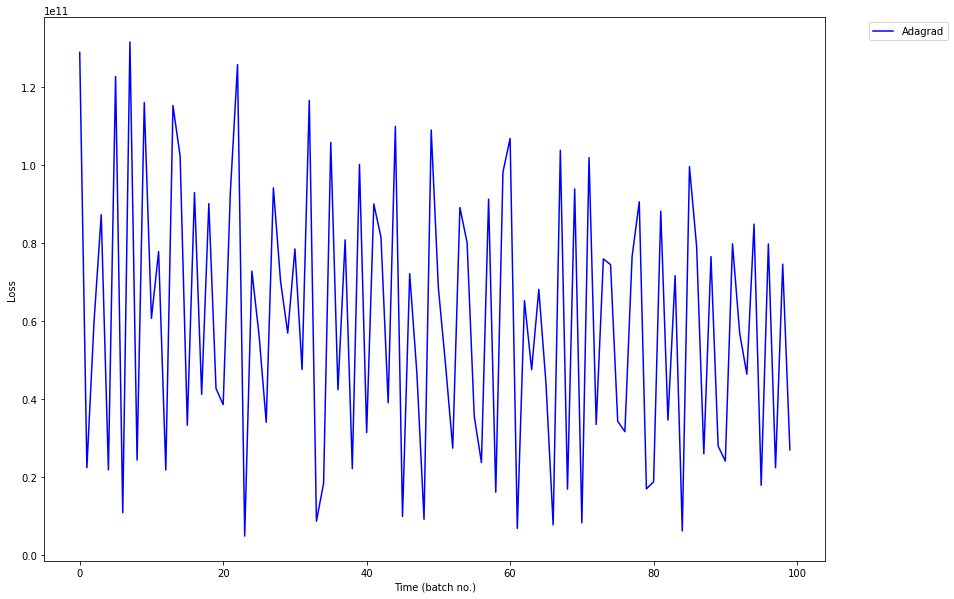

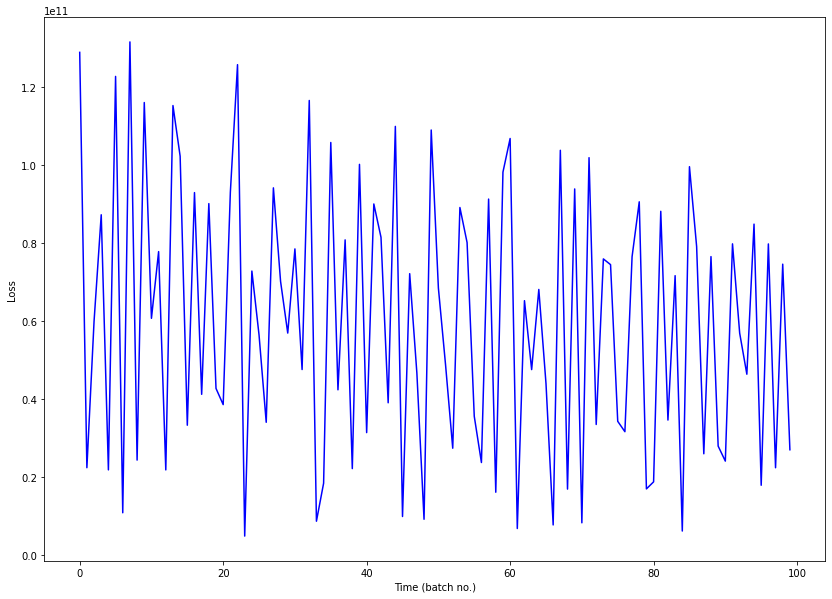

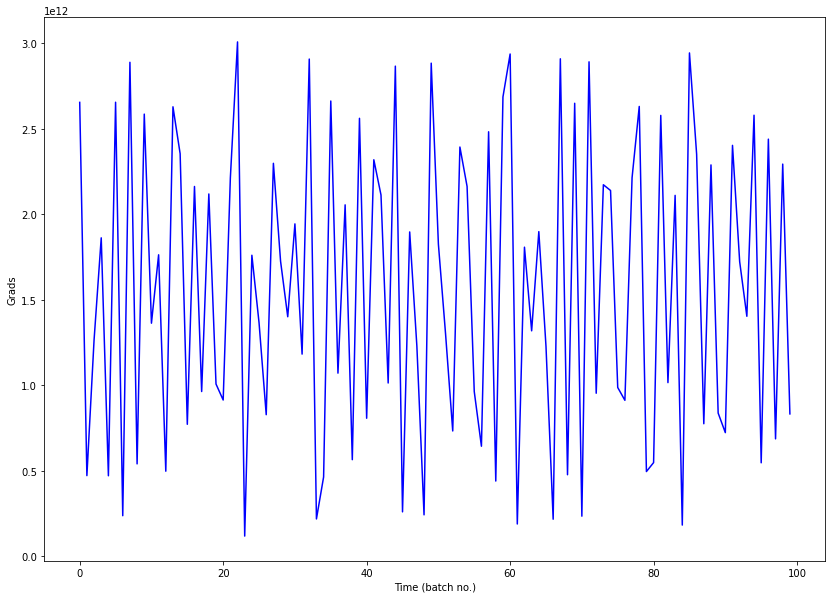

In [6]:
#Plots to compare training on different optimizers
colours = ['b', 'c', 'y', 'r']
plots = []
epochs = 50
plot_times = [i for i in range(int(epochs*(n/batch_size)))]

#Plot graph of training time vs loss values for each optimizer
plt.figure(figsize=(14, 10))
for i in range(len(optimizer_list)):
    p, = plt.plot(plot_times,all_losses[i],color=colours[i],label=optimizer_names[i])
    plots.append(p)
plt.legend(handles=plots, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Time (batch no.)')
plt.ylabel('Loss')

plt.show()

#Plot of graph of training time vs loss values for last optimizer
plt.figure(figsize=(14, 10))
plt.plot(plot_times,all_losses[0],color=colours[0],label=optimizer_names[0])
plt.xlabel('Time (batch no.)')
plt.ylabel('Loss')

plt.show()

#Plot graph of training time vs gradient values for each optimizer
plt.figure(figsize=(14, 10))
for i in range(len(optimizer_list)):
    y = all_grads[i]
    p, = plt.plot(plot_times,y,color=colours[i],label=optimizer_names[i])
    plots.append(p)    
#plt.legend(handles=plots, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Time (batch no.)')
plt.ylabel('Grads')

plt.show()


In [ ]:
#Plots to compare the variance of output f(x) (for many different initialisations) vs. the choice of d
colours = ['b', 'c', 'y', 'r']
plots = []
epochs = 50
plot_times = [i for i in range(int(epochs*(n/batch_size)))]

#Plot graph of training time vs loss values for each optimizer
plt.figure(figsize=(14, 10))
for i in range(len(optimizer_list)):
    p, = plt.plot(degree_list,all_variances[i],color=colours[i],label=degree_list[i])
    plots.append(p)
plt.legend(handles=plots, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Degree')
plt.ylabel('Variance')

plt.show()